In [1]:
import numpy as np
import plotly.graph_objects as go
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel

import sys
import os
# 使用当前工作目录
project_root = os.path.dirname(os.getcwd())  # 获取当前目录的父目录
sys.path.insert(0, project_root)
from util.methods import assign_variances

seed = 16
# 定义核函数
kernel = ConstantKernel(25.0) * RBF(length_scale=4.0) + WhiteKernel(1e-3)
gp = GaussianProcessRegressor(kernel=kernel)

x_dense = np.linspace(1, 200, 2000).reshape(-1, 1)

y_dense = gp.sample_y(x_dense, n_samples=1, random_state=seed).flatten() + 70

# 提取整数点对应的y值
integer_points = np.arange(1, 201)
y_integers = y_dense[np.linspace(0, 1999, 200, dtype=int)]

# 计算整数点的协方差矩阵
cov_matrix = kernel(integer_points.reshape(-1,1))

# 计算相关性矩阵
std_dev = np.sqrt(np.diag(cov_matrix))  
corr_matrix = cov_matrix / np.outer(std_dev, std_dev)  

np.savetxt('Sigma1.txt', cov_matrix, 
           fmt='%.6f',
           header=f'高斯过程协方差矩阵\n核函数: {kernel}')

np.savetxt('correlation_matrix.txt', corr_matrix,
           fmt='%.6f',
           header=f'高斯过程相关性矩阵\n核函数: {kernel}')

np.savetxt('mu.txt', 
           y_integers,
           fmt='%.6f',
           header='真实均值')

# 创建分组标签 (5组，每组10个点)
group_labels = np.floor(np.argsort(np.argsort(y_integers))/25).astype(int)
group_names = [f"第{i+1}组" for i in range(8)]  # 组别名称

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x_dense.flatten(), 
    y=y_dense,
    mode='lines',
    name='GP曲线',
    line=dict(color='royalblue', width=2)
))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#f5fa07', '#07faec', '#f808b9']  # 8种不同颜色
for group in range(8):
    mask = (group_labels == group)
    fig.add_trace(go.Scatter(
        x=integer_points[mask],
        y=y_integers[mask],
        mode='markers',
        name=group_names[group],
        marker=dict(
            color=colors[group],
            size=8,
            line=dict(width=1, color='DarkSlateGrey')
    )))

fig.update_layout(
    title='高斯过程曲线与分组结果',
    xaxis_title='x',
    yaxis_title='f(x)',
    template='plotly_white',
    height=1080,
    width=1920,
    legend=dict(
        title='组别',
        x=1.05,
        y=1,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.8)'
    ),
    margin=dict(r=150) 
)

fig.show()

In [2]:
eigvals = np.linalg.eigvals(cov_matrix)
print("最小特征值:", np.min(eigvals))
print("负特征值数量:", np.sum(eigvals < 0))

最小特征值: (0.0009999999999870059+0j)
负特征值数量: 0


验证结果:
对角线均值: 1.000000 (目标: 1.0)
最小特征值: 0.000000+0.000000j (应>0)


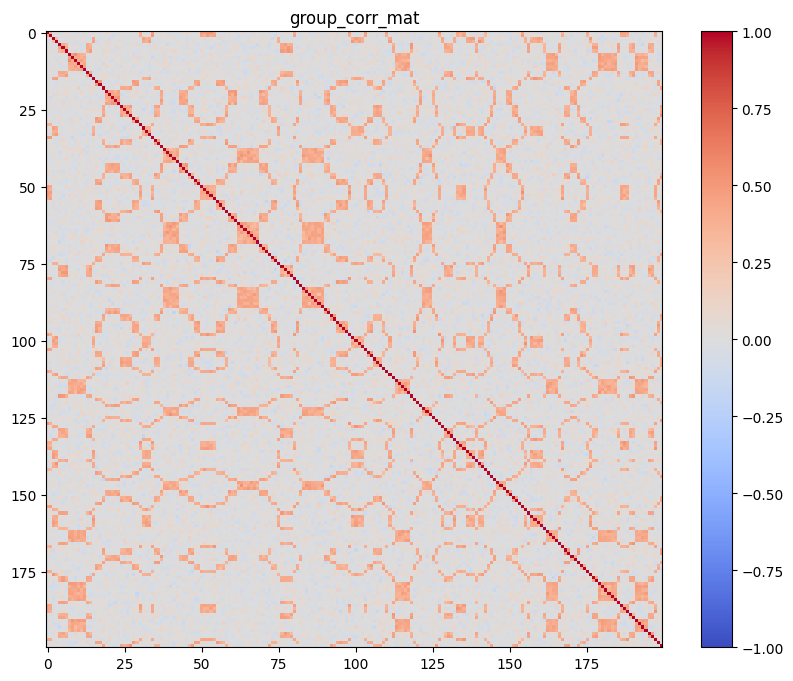

In [3]:
import numpy as np
from scipy.linalg import cholesky
import matplotlib.pyplot as plt

# 初始化参数
n_points = 200
within_group_mean = 0.5
between_group_mean = 0.0
noise_std = 0.1 

np.random.seed(seed=seed)

def build_correlation_matrix(group_labels):
    groups = np.unique(group_labels)
    n_groups = len(groups)
    group_mask = group_labels[:, None] == group_labels  
    
    base_matrix = np.where(group_mask, 
                          within_group_mean, 
                          between_group_mean)
    np.fill_diagonal(base_matrix, 1.0)
    
    random_matrix = np.random.normal(0, noise_std, (n_points, n_points))
    random_matrix = (random_matrix + random_matrix.T) / 2  
    np.fill_diagonal(random_matrix, 0) 
    
    corr_matrix = base_matrix + random_matrix
    

    def project_to_pd(matrix):
        eigvals, eigvecs = np.linalg.eigh(matrix)
        eigvals = np.maximum(eigvals, 1e-8)  
        return eigvecs @ np.diag(eigvals) @ eigvecs.T
    

    for _ in range(10):
        corr_matrix = project_to_pd(corr_matrix)
        # 重新标准化对角线
        diag_scaling = np.diag(1/np.sqrt(np.diag(corr_matrix)))
        corr_matrix = diag_scaling @ corr_matrix @ diag_scaling
    
    return corr_matrix

corr_matrix = build_correlation_matrix(group_labels)

# 验证矩阵性质
print("验证结果:")
print(f"对角线均值: {np.mean(np.diag(corr_matrix)):.6f} (目标: 1.0)")
print(f"最小特征值: {np.min(np.linalg.eigvals(corr_matrix)):.6f} (应>0)")

# 可视化矩阵
plt.figure(figsize=(10,8))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title("group_corr_mat")
plt.show()

In [4]:
group_labels+1

array([5, 5, 6, 6, 7, 7, 7, 8, 8, 8, 8, 8, 8, 7, 7, 6, 4, 4, 3, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 4, 4, 5, 6, 6, 6, 5, 3, 3, 2, 1, 1, 1, 1, 1, 2,
       2, 2, 3, 3, 4, 4, 5, 5, 5, 5, 5, 4, 4, 4, 3, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 3, 4, 4, 6, 7, 7, 7, 7, 5, 4, 2, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 3, 3, 4, 4, 4, 4, 5, 6, 6, 6, 6, 5, 4, 4, 3, 3, 3, 4,
       5, 6, 7, 8, 8, 8, 8, 8, 7, 4, 3, 2, 1, 1, 1, 2, 3, 5, 6, 7, 7, 7,
       6, 5, 5, 5, 6, 6, 6, 7, 6, 6, 5, 4, 3, 2, 1, 1, 1, 2, 2, 3, 3, 4,
       5, 6, 7, 6, 6, 6, 6, 7, 8, 8, 8, 8, 7, 5, 3, 3, 2, 2, 3, 4, 4, 5,
       6, 7, 7, 8, 8, 8, 8, 8, 8, 7, 5, 5, 5, 7, 7, 8, 8, 8, 8, 7, 7, 5,
       4, 3])

验证结果:
方差范围: 27.09-134.62 (目标: 25-144)
最小特征值: 0.000000 (应>0)


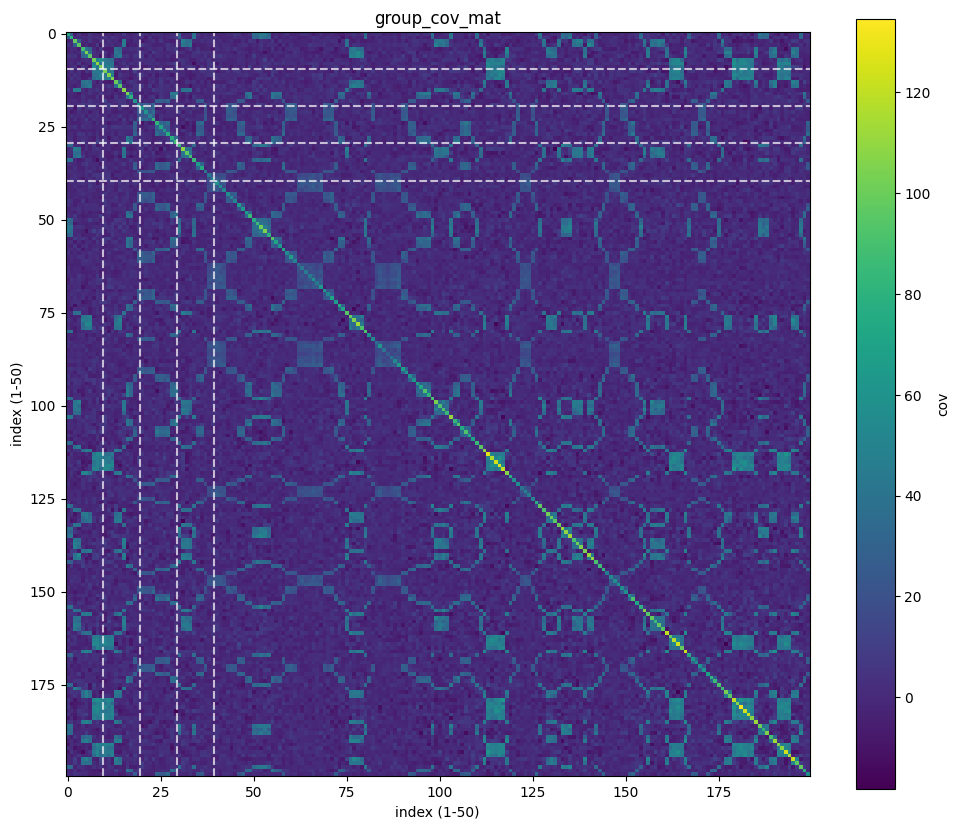

In [5]:
# 随机分配噪声
np.random.seed(seed)  
variances = assign_variances(y_integers, min_var=25, max_var=144, correlation_strength=0.7)
#variances = variances*4
std_devs = np.sqrt(variances)  

D = np.diag(std_devs)

cov_matrix = D @ corr_matrix @ D

print("验证结果:")
print(f"方差范围: {np.min(np.diag(cov_matrix)):.2f}-{np.max(np.diag(cov_matrix)):.2f} (目标: 25-144)")
print(f"最小特征值: {np.min(np.linalg.eigvals(cov_matrix)):.6f} (应>0)")

np.savetxt('group_cov.txt', 
           cov_matrix,
           fmt='%.6f',
           header='协方差矩阵（对角线方差=25-144）\n基于分组相关性矩阵生成')

import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
plt.imshow(cov_matrix, cmap='viridis')
cbar = plt.colorbar()
cbar.set_label('cov')

for g in range(1,5):
    plt.axhline(y=g*10-0.5, color='white', linestyle='--', alpha=0.7)
    plt.axvline(x=g*10-0.5, color='white', linestyle='--', alpha=0.7)

plt.title('group_cov_mat')
plt.xlabel('index (1-50)')
plt.ylabel('index (1-50)')
plt.show()


In [6]:
y_integers

array([71.66191648, 72.5260336 , 73.13823192, 73.61279625, 74.33560331,
       75.20779314, 76.07546475, 76.91597549, 77.59529759, 77.87426219,
       77.8052521 , 77.30007592, 76.50993669, 75.63812143, 74.53005166,
       73.08237048, 71.34954094, 69.58414494, 67.69125949, 66.16753171,
       65.23888007, 64.93363591, 65.26287011, 66.02892314, 66.72250139,
       67.31335441, 67.82451681, 68.39239169, 69.41368829, 70.68278081,
       72.18384357, 73.44293701, 73.89566785, 73.19859281, 71.40326886,
       68.94764344, 66.58117636, 64.47927638, 63.15838489, 62.59694862,
       62.686192  , 63.08064041, 63.57843319, 64.28414787, 65.2061727 ,
       66.33190023, 67.66173658, 68.95899966, 70.18813998, 71.13534432,
       71.7051092 , 71.98420864, 72.03096188, 72.04905079, 71.85598319,
       71.36838586, 70.41162724, 69.24868946, 67.85251737, 66.54076896,
       65.41075175, 64.55636807, 63.66841705, 62.83771402, 62.29910974,
       62.23377354, 62.48940311, 63.08943022, 63.75899705, 64.41

In [7]:
variances

array([ 74.67318697,  82.01696202,  97.67835631,  96.33282433,
        89.05899367, 105.13799675,  96.66264379, 102.3503099 ,
       110.02170151, 103.22500145, 104.05949349, 105.80652709,
       105.08714385,  99.49324447,  96.24488485, 107.93430206,
       104.96135447,  80.62081192,  62.57710425,  56.84711802,
        65.08564639,  60.75496557,  48.237153  ,  83.36589875,
        81.08278827,  72.8803967 ,  62.14836039,  76.76272271,
        78.08080245,  88.3216571 ,  84.31779132, 109.05892638,
        96.36596698,  89.61530548,  86.00025584,  66.96032698,
        75.97219197,  43.39389605,  43.4758901 ,  45.40749675,
        60.93207028,  58.19966219,  50.03989972,  57.94445947,
        53.80858393,  50.89863509,  65.87915079,  63.59955582,
        67.78622847,  84.79415281,  76.88975165,  86.26806336,
       101.94422384, 105.13050407,  79.23577059,  93.65333737,
        72.52829823,  63.00030256,  72.67971794,  56.70061838,
        68.07207589,  49.70304993,  38.13441108,  42.65